Paper: Using random testing in a feedback-control loop to manage a safe exit from the COVID-19 lockdown
Markus Mu ̈ller,

source: https://www.medrxiv.org/content/10.1101/2020.04.09.20059360v2



### Appendix B: Algorithm to simulate mitigation of reboot
### 1. Definitions

• $t=1,2, \cdots$ : Time in days (integer).

• $n_{int}$ : Number of interventions (including the reboot
at $t = 1$).

• $t_{int}(j)$ : First day on which the $j$th rate $k_j$ applies.
<br>
On day $t_{int}(1) ≡ 1$ the initial reboot step is taken.

• $∆t(j) = t_{int}(j + 1) − t_{int}(j)$ : Time span between
interventions $j$ and $j + 1$.

• $t_{ {first }}$: First day on which the current rate $k = k(t)$ is applied.

• $i(t)$ : Fraction of infected people on day $t$.

• $k(t)$ : Growth rate on day $t$.

• $r$ : Number of tests per day.

• $C_{H}$ : Health cost.

• $C_{E}$ : Economic cost.

• $k_{min} = 0.005$ : Minimal growth rate targeted.

• $i_{low} = 0.2$ : Lower threshold for $i / i^{*}$ . If $i / i^{*}<i_{\mathrm{low}}$, a relaxing intervention is made, irrespective of the estimate of $k$.

• $i_{high} = 3$ : Upper threshold for i/i∗. If If $i / i^{*}>i_{\text {high }}$, an intervention is made even if k is still smaller than $α δk$.

• $k_{low} = −0.1$ : Minimal possible decreasing rate considered.

• $k_{high} = 0.23$ : Maximal possible increasing rate considered.

• $T_{min} = 3$: Minimal time to wait since the last intervention, for interventions based on the level of $i(t)$.

• $b$ : Parameter defining the possible range of changes ∆k due to measures taken after estimating $k$. $|∆k/kest| ∈ [b, 1/b]$. Usually we set $b = 0.5$.

• $α$ : Confidence parameter.

• $N(t)$ : Cardinality of random sample of infected people on day $t$. The number $N(t)$ is obtained by sampling from a Gaussian distribution of mean $i(t) r$ and standard deviation $\sqrt{i(t) r}$ and rounding the obtained real number to the next non-negative integer.

### 2. Initialization
• $t_{first} = t_{int}(1) = 1$. 

• $n_{int} = 1$.

• $C_{H} = 1$.

• $C_{E} = 0$.

• $k(1) = k1 = 0.1$ . (Initial growth rate)

• $i(1) = i^∗$. Common choice $i^∗ = i /4 = 0.0007$.

• Draw $N(1)$.

• $k(2) = k(1)$. (No intervention at the end of day 1) 

• Set $t = 2$.


### 3. Daily routine for day t

Define $i(t)=i(t-1) e^{k(t-1)}$, 

Define $C_{\mathrm{H}}=\max \left\{C_{\mathrm{H}}, i(t) / i^{*}\right\}$, 

Define $C_{E} = C_{E} − k(t)$.

Draw $N(t)$.

Determine what will be $k(t + 1)$, by assessing whether or not to intervene:
<br>
If $t = t_{first}$, then $k(t + 1) = k(t)$. (No intervention) 
<br>
Else Distinguish three intervention cases:

1. If $i(t) / i^{*}<i_{\text {low }}$ and $t-t_{\text {first }} \geq T_{\text {min }}$, 
<br>
then $k(t+1)=\min \left\{k(t)+x k_{1}, 
<br>
k_{\mathrm{high}}\right\}$ 
<br> 
with $x=\operatorname{Unif}[0,1]$


2. ElseIf $i(t) / i^{*}>i_{\text {high }}$ and $t-t_{\text {first }} \geq T_{\text {min }}$, 
<br>
then $z(t+1)=\max \left\{k(t)-(1+x) / 2 k_{\text {high }}, k_{\text {low }}\right\}$
<br> 
with $x=\operatorname{Unif}[0,1]$


3. ElseIf $i_{\text {low }}<i(t) / i^{*}<i_{\text {high }}$, 
<br>
then 
<br>
    - set $∆t ≡ t − t_{first} + 1$
<br>
    - Compute $k_{\mathrm{est}}\left(t_{\mathrm{first}}, \Delta t\right),$ and $\delta k_{\mathrm{est}}\left(t_{\mathrm{first}}, \Delta t\right)$
<br>
using Sec. B4
<br>
If $\left|k_{\text {est }}\right|>k_{\text {min }}$ 
<br>
AND $\left[k_{\mathrm{est}}>\alpha \delta k_{\mathrm{est}} \mathbf{O R} 
<br>
k_{\mathrm{est}}<-\alpha \delta k_{\mathrm{est}}\right]$
<br>
set 
<br>
$k(t+1)=k(t)-x k_{\mathrm{est}}$
with $x=\operatorname{Unif}[b, 1 / b]$
<br>
If $k(t+1)>k_{\text {high }},$ put $k(t+1)=k_{\text {high }}$
<br>
If $k(t+1)<k_{\text {low }},$ put $k(t+1)=k_{\text {low }}$
        
        
        
4. Else $k(t + 1) = k(t)$



$t=t+1$.


### 4. Estimate of k_est


# Code

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
# N(t): Cardinality of random sample of infected people on day t. 
# The number N(t) is obtained by sampling from a Gaussian distribution of mean i(t) r and standard deviation
# i(t)r and rounding the obtained real number to the next non-negative integer.
def get_N(t, i, r):
    import math
    mean = i[t]*r
    std  = mean**0.5
    return math.ceil(np.random.normal(loc=mean, scale=std))

In [3]:
def estimate_k_est(t_first, delta_t, N):
    if delta_t % 2 == 0:
        half = delta_t // 2
        N_1 = sum([N[t_first + m] for m in range(half)])
        N_2 = sum([N[t_first + half + m] for m in range(half)])
        if N_1*N_2 > 0:
            k_est = 2/delta_t * math.log(N_2 / N_1)
            delta_k_est = 2/delta_t * (1/N_1 + 1/N_2)**0.5
        else:
            k_est, delta_k_est = (0, 1000)
    else:
        sum_to = (delta_t - 1)//2
        N_1 = sum([N[t_first + m] for m in range(sum_to)])
        N_m = N[t_first + sum_to]
        N_2 = sum([N[t_first + (delta_t + 1)//2 + m] for m in range(sum_to)])
        N_1_dash = N_1 + N_m
        N_2_dash = N_2 + N_m
        
        if N_1 * N_2 > 0:
            k_est = (2/(delta_t - 1)) * math.log(N_2/N_1)
            delta_k_est = (2/(delta_t - 1))*(N_2_dash/(N_2**2) + N_1_dash/(N_1**2) + N_m * (1/N_2 - 1/N_1)**2)**0.5
        else:
            k_est, delta_k_est = (0, 1000)
    return k_est, delta_k_est

In [4]:
def run_model(
    # number of days to run for
    t_until,
    # fixed values?
    i_low = 0.2,
    i_high = 3,
    i_star = 0.007, # (safe reboot with instataneous growth rate known with random testing - if i< ic/4)
    #i_star = 0.0014, # ic/20 (reboot only possible if i< ic/20)
    
    k_min = 0.005,
    k_low = -0.1,
    k_high = 0.23,
    T_min = 3,
    b = 0.5,
    alpha = 2,
    # variable arguments
    r = 15000,
    n_int = 1,
    C_h = 1,
    C_e = 0,
    k_init = 0.1,
    feature = None
):
    t_first = 0
    k = [k_init, k_init]
    i = [i_star]
    N = [get_N(0, i, r)]
    C_e = [C_e]
    C_h = [C_h]
    interventions = [0]

    for t in range(1, t_until):
        intervention = False
        i.append(i[t-1]*math.e**(k[t-1]))
        i_t_div_i_star = i[t] / i_star

        C_h.append(max(C_h[t-1], i_t_div_i_star))
        C_e.append(C_e[t-1] - k[t])
       
        N.append(get_N(t, i, r))

        minimal_time_to_wait_exceeded = t - t_first >= T_min
        if i_t_div_i_star < i_low and minimal_time_to_wait_exceeded:
            # infection rate is lower than desired threshold so ease restrictions
            x = np.random.uniform()
            k.append(k[t] + x*k[0])
            intervention = True
        elif i_t_div_i_star > i_high and minimal_time_to_wait_exceeded:
            # infection rate is higher than desired threshold so increase restrictions
            x = np.random.uniform()
            k.append(k[t] - (1+x)/(2 * k_high))
            intervention = True
        elif i_low < i_t_div_i_star and i_t_div_i_star < i_high:
            delta_t = t - t_first + 1
            k_est, delta_k_est = estimate_k_est(t_first, delta_t, N)

            if abs(k_est) > k_min and (k_est > alpha*delta_k_est or k_est < -alpha*delta_k_est):
                # if it's growing or shrinkly quickly, intervene
                x = np.random.uniform(b, 1/b)
                k.append(k[t] - x * k_est)
                intervention = True
            else:
                k.append(k[t])
        else:
            k.append(k[t])
        
        if intervention:
            t_first = t + 1 # the intervention happens tomorrow
        interventions.append(1 if intervention else 0)
        
        # limit k to be in [k_low, k_high]
        k[t + 1] = min(k[t + 1], k_high)
        k[t + 1] = max(k[t + 1], k_low)
    k.pop()
    suffix = f'_{feature}' if feature else ''
    return pd.DataFrame({
        f'k{suffix}': k,
        f'N{suffix}': N,
        f'i{suffix}': i,
        f'c_h{suffix}': C_h,
        f'c_e{suffix}': C_e,
        'intervention': interventions
    })


def plot(results, feature, kind):
    plt.xlabel('day since t=0')
    results[[feature]].plot(kind=kind, logy=True)
    


In [7]:
run_model_100 = run_model(t_until = 100)
run_model_100.head()

,k,N,i,c_h,c_e,intervention
0,0.1,115,0.007000,1.000000,0.0,0
1,0.1,120,0.007736,1.105171,-0.1,0
2,0.1,127,0.008550,1.221403,-0.2,0
3,0.1,151,0.009449,1.349859,-0.3,0
4,0.1,165,0.010443,1.491825,-0.4,1


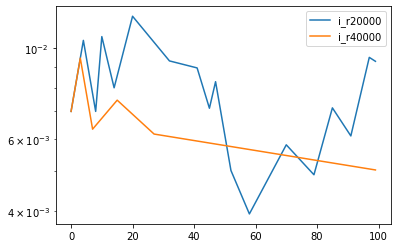

In [9]:
#quick model check
r20000 = run_model(t_until = 100, r = 20000, feature='r20000') ##one run with number of tests = 20000
r40000 = run_model(t_until = 100, r = 40000, feature='r40000') ##one run with number of tests = 40000
pd.concat([r20000, r40000], axis = 1)[['i_r20000', 'i_r40000']].plot(kind='line', logy=True)

# Plots for numbers of test and interventions
Notes: 
- Intervention flag is when intervention decision is made. The effect of the intervention takes place the next day
- Although intervention flags are useful for understanding how often the chosen number of tests (r) triggers an intervention by hitting the limit of the targeted growth rate interval (k_high or k_low), the randomness in the model (obtained through a random draw of infected people on day t using N(t) ) means that we need to take averages over multiple simulations - we will do this below

In [10]:
def make_intervention_df(df, plot_feature, r):
    intervention_df = df[df['intervention']==1]
    intervention_df = intervention_df[[f'{plot_feature}_r{r}']].reset_index().rename(columns={'index': 'day'})
    return intervention_df

def interventions_plots(t_until, r, plot_feature):
    #run model with selected features
    r_df = run_model(t_until = t_until, r = r, feature= f'r{r}')
    #flag for days that an intervention took place
    intervention_df = make_intervention_df(r_df, plot_feature= plot_feature, r=r)
    
    plt.plot(r_df[f'{plot_feature}_r{r}'], 'g--')
    plt.plot(intervention_df['day'], intervention_df[f'{plot_feature}_r{r}'], 'o')
    plt.title(f'Number of Tests = {r}')
    plt.suptitle('Fraction of Infected People Per Day, and flag for intervention')
    plt.xlabel('Days after Reboot')
    plt.ylabel('Fraction of Infected People')


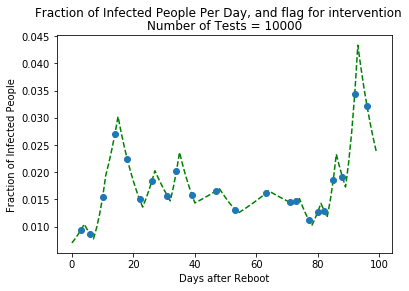

In [25]:
#10000 tests
interventions_plots(t_until = 100, r = 10000, plot_feature = 'i')

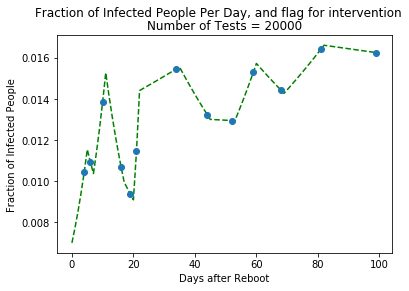

In [11]:
#20000 tests
interventions_plots(t_until = 100, r = 20000, plot_feature = 'i')

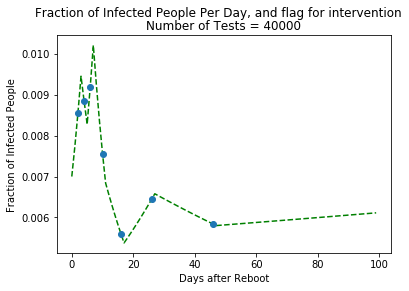

In [22]:
#40000 tests
interventions_plots(t_until = 100, r = 40000, plot_feature = 'i')

# Multiple Runs and Averaging
Notes:
- When running multiple simulations to take an average, we lose the information whether there was an intervention
- To account for this, we look at average number of interventions over the n_runs, to check that our final results are similar
- We expect that on average, the number of interventions for a smaller number of tests will be lower than the number of interventions when r is larger (because more test provides a growth rate with less time delay)

In [51]:
def check_avg_number_interventions(n_runs, r, t_until):
    total_interventions = []
    for i in range(n_runs):
        model = run_model(t_until = t_until, r = r)
        #return model
        intervention_number = (model['intervention'].sum())
        total_interventions.append(intervention_number)
    print(sum(total_interventions)/(t_until*n_runs)*100, '%')
                

        
#average over 100 times
check_avg_number_interventions(n_runs=100, r=10000, t_until=100)


8.82 %


In [52]:
check_avg_number_interventions(n_runs=100, r=20000, t_until=100)

10.0 %


In [53]:
check_avg_number_interventions(n_runs=100, r=40000, t_until=100)

9.22 %


In [57]:
def run_for_many_rs(n_runs, feature, feature_explanation, rs, params = {}):
    results = [
        [
            run_model(r = r, feature = f'r{str(r)}', **params).drop('intervention', axis=1)
            for i in range(n_runs)
        ]
        for r in rs
    ]
    results = [sum(group) / n_runs for group in results]
    results = pd.concat(results, axis=1)
    return results

def run_and_plot_for_many_rs(n_runs, feature, feature_explanation, rs, params = {}):
    results = run_for_many_rs(n_runs, feature, feature_explanation, rs, params)
    i_star = params.get('i_star', 0.0007)
    features = [f'{feature}_r{r}' for r in rs]
    ax = results[features].plot(kind='line', logy=True, title='Infection Rate for number of tests (r) ', figsize=(15, 5))
    if feature == 'i':
        ax.hlines([0.2 * i_star, 3 * i_star, i_star], ax.get_xticks().min(), ax.get_xticks().max(), linestyle='--', color='pink')
    ax.set_xlabel("Days after Economy Reboot")
    ax.set_ylabel(f'{feature_explanation}')
    

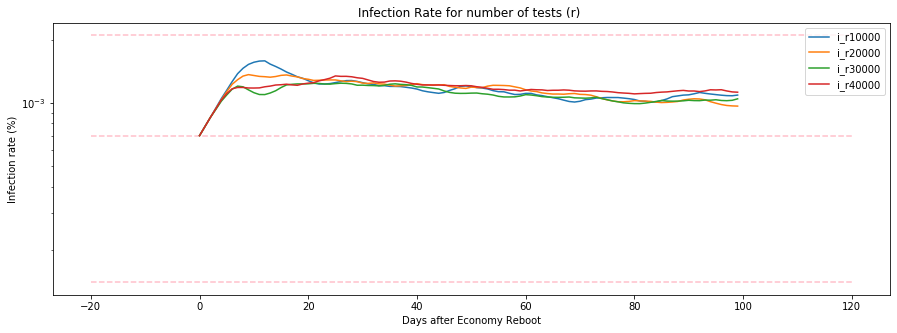

In [42]:
run_and_plot_for_many_rs(100, 'i', 'Infection rate (%)', [10000, 20000, 30000, 40000], {
    't_until': 100,
    'i_star': 0.0007
})


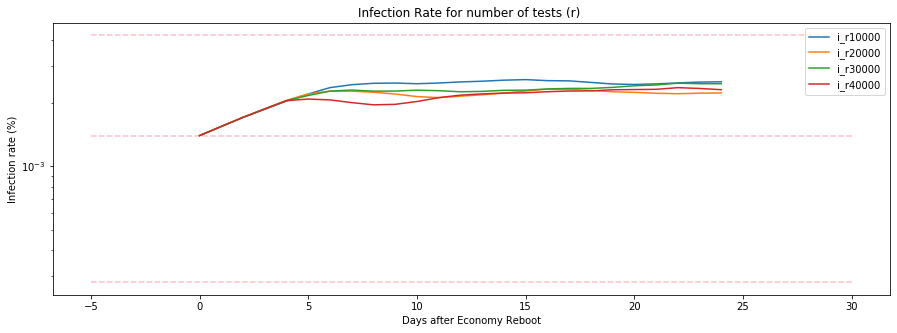

In [45]:
run_and_plot_for_many_rs(50, 'i', 'Infection rate (%)', [ 10000, 20000, 30000, 40000], { 
    't_until': 25,
    'i_star': 0.0014 
})




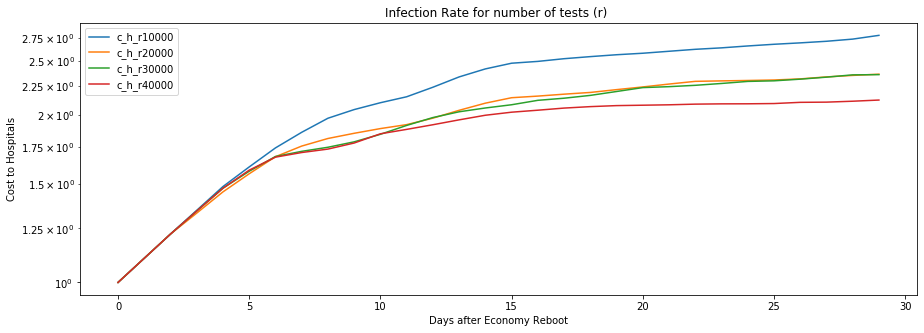

In [46]:
run_and_plot_for_many_rs(50, 'c_h', 'Cost to Hospitals', [10000, 20000, 30000, 40000], { 
    't_until': 30,
    'i_star': 0.0014 
})

Text(0, 0.5, 'Inference of Infection Growth Rate (k_fit)')

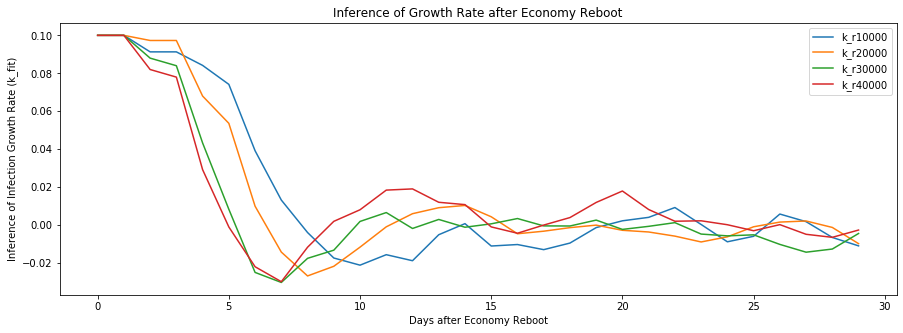

In [36]:

#different plot function for k (inference of growth rate) because model allows min_k = -0.1

##simulation is average over 100 days
#run for t_until = 30 days 
#set i* = 0.0014 
results = run_for_many_rs(100, 'i', 'Infection rate (%)', [ 10000, 20000, 30000, 40000], { 't_until': 30, 'i_star': 0.0014 })

ax = results[list(filter(lambda x: 'k' in x, results.columns))].plot(figsize=(15, 5), title='Inference of Growth Rate after Economy Reboot')
ax.set_xlabel("Days after Economy Reboot")
ax.set_ylabel('Inference of Infection Growth Rate (k_fit)')

# Hospitalisation rates 
Source: https://www.ecdc.europa.eu/sites/default/files/documents/covid-19-rapid-risk-assessment-coronavirus-disease-2019-eighth-update-8-april-2020.pdf (European Centre for Disease Prevention and Control)


- Among all cases: Hospitalisation occurred in 32% of cases reported from 26countries (median country-specific estimate, interquartile range (IQR): 28%, 14–63%)
- Severe illness (requiring ICU and/or respiratory support) accounted for 2859 of 120788 (2.4%) cases reported from 16 countries (median, IQR: 1.4%, 0–33%).


- Among hospitalised cases: Severe illness was reported in 9.2% (3567of 38960) of hospitalised cases from 19countries (median, IQR: 15%, 3.8–35%).
- Death occurred in 1005 of 9368 (11%) hospitalised cases from 21countries (median, IQR: 3.9%, 0–13%)


In [ ]:
total_population = 46940000 #spain
#total_population = 8570000 #switzerland
icu_hosp_rate = 0.024 #severe illness (require ICU) hospitalisation rate 


In [61]:
results1 = run_for_many_rs(100, 'i', 'Infection rate (%)', [10000, 20000, 30000, 40000], {
    't_until': 20,
    'i_star': 0.0007
})

In [107]:
results1.head()

,k_r10000,N_r10000,i_r10000,c_h_r10000,c_e_r10000,k_r20000,N_r20000,i_r20000,c_h_r20000,c_e_r20000,k_r30000,N_r30000,i_r30000,c_h_r30000,c_e_r30000,k_r40000,N_r40000,i_r40000,c_h_r40000,c_e_r40000
0,0.1000,7.62,0.000700,1.000000,0.0000,0.100000,14.91,0.000700,1.000000,0.000000,0.100000,21.55,0.000700,1.000000,0.000000,0.100000,28.50,0.000700,1.000000,0.000000
1,0.1000,8.32,0.000774,1.105171,-0.1000,0.100000,14.94,0.000774,1.105171,-0.100000,0.100000,23.56,0.000774,1.105171,-0.100000,0.100000,32.16,0.000774,1.105171,-0.100000
2,0.0993,9.38,0.000855,1.221403,-0.1993,0.101300,16.93,0.000855,1.221403,-0.201300,0.087300,26.50,0.000855,1.221403,-0.187300,0.091300,34.88,0.000855,1.221403,-0.191300
3,0.0993,10.72,0.000945,1.350448,-0.2986,0.101300,19.01,0.000946,1.351733,-0.302600,0.087300,28.53,0.000934,1.342741,-0.274600,0.091300,38.19,0.000938,1.345310,-0.282600
4,0.0846,10.53,0.001044,1.493550,-0.3832,0.087716,21.28,0.001047,1.496254,-0.390316,0.056373,32.16,0.001023,1.477325,-0.330973,0.062086,41.18,0.001030,1.482733,-0.344686


In [108]:
def add_icu_numbers(df, icu_rate, population):
    i_columns = list(filter(lambda x: 'i' in x, df.columns))
    # multiply i by population and icu_rate
    icu_numbers = df[i_columns] * icu_rate * population
    # postfix columns with _icu
    icu_numbers = icu_numbers.rename({ x: f'{x}_icu' for x in i_columns}, axis=1)
    return pd.concat([df, icu_numbers], axis=1)

add_icu_numbers(results1, 0.024, 46940000)
    

,k_r10000,N_r10000,i_r10000,c_h_r10000,c_e_r10000,k_r20000,N_r20000,i_r20000,c_h_r20000,c_e_r20000,...,c_e_r30000,k_r40000,N_r40000,i_r40000,c_h_r40000,c_e_r40000,i_r10000_icu,i_r20000_icu,i_r30000_icu,i_r40000_icu
0,0.100000,7.62,0.000700,1.000000,0.000000,0.100000,14.91,0.000700,1.000000,0.000000,...,0.000000,0.100000,28.50,0.000700,1.000000,0.000000,788.592000,788.592000,788.592000,788.592000
1,0.100000,8.32,0.000774,1.105171,-0.100000,0.100000,14.94,0.000774,1.105171,-0.100000,...,-0.100000,0.100000,32.16,0.000774,1.105171,-0.100000,871.528945,871.528945,871.528945,871.528945
2,0.099300,9.38,0.000855,1.221403,-0.199300,0.101300,16.93,0.000855,1.221403,-0.201300,...,-0.187300,0.091300,34.88,0.000855,1.221403,-0.191300,963.188444,963.188444,963.188444,963.188444
3,0.099300,10.72,0.000945,1.350448,-0.298600,0.101300,19.01,0.000946,1.351733,-0.302600,...,-0.274600,0.091300,38.19,0.000938,1.345310,-0.282600,1064.036079,1065.965668,1052.458544,1056.317722
4,0.084600,10.53,0.001044,1.493550,-0.383200,0.087716,21.28,0.001047,1.496254,-0.390316,...,-0.330973,0.062086,41.18,0.001030,1.482733,-0.344686,1176.055739,1179.934229,1152.784798,1160.541778
5,0.082600,12.57,0.001139,1.642049,-0.465800,0.079716,23.84,0.001145,1.645603,-0.470032,...,-0.375800,0.037379,44.89,0.001102,1.607350,-0.382065,1283.454308,1290.324487,1228.762583,1241.224166
6,0.050188,12.83,0.001245,1.805792,-0.515988,0.036438,25.84,0.001246,1.804490,-0.506470,...,-0.392670,-0.007941,47.40,0.001156,1.726142,-0.374124,1402.560134,1403.964995,1302.596011,1302.739914
7,0.048188,13.66,0.001320,1.951796,-0.564176,-0.001934,25.85,0.001301,1.926426,-0.504537,...,-0.381719,-0.025471,48.15,0.001162,1.796674,-0.348653,1487.007207,1465.793674,1337.539718,1309.236741
8,0.029030,14.42,0.001406,2.111975,-0.593206,-0.007328,24.72,0.001312,2.010997,-0.497209,...,-0.365043,-0.035895,45.34,0.001152,1.852325,-0.312758,1583.990242,1477.646125,1340.763407,1297.658274
9,0.008639,14.99,0.001470,2.248116,-0.601845,-0.005290,26.90,0.001320,2.082737,-0.491918,...,-0.354381,-0.025142,44.94,0.001127,1.878990,-0.287616,1656.044458,1486.530036,1335.244097,1269.651525


No handles with labels found to put in legend.


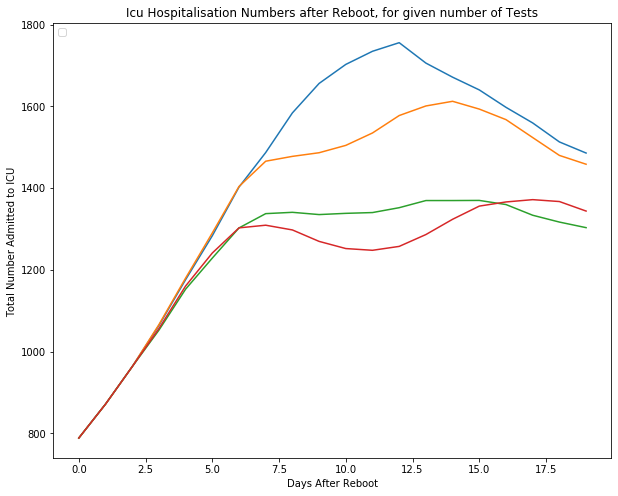

In [148]:
def plot_icu_numbers(df, icu_rate, population):
    #add icu numbers to result df
    with_icu_df = add_icu_numbers(df, 0.024, 46940000)

    #icu numbers to plot
    icu_columns = with_icu_df.columns[with_icu_df.columns.str.contains('icu')]
    is_df = with_icu_df[icu_columns]

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(is_df)
    ax.set_title('Icu Hospitalisation Numbers after Reboot, for given number of Tests')
    ax.legend(loc='upper left')
    ax.set_ylabel('Total Number Admitted to ICU ')
    ax.set_xlabel('Days After Reboot')
    
    
plot_icu_numbers(results1, icu_rate = 0.024, population = 46940000)
    
    
    

In [149]:
#results1[list(filter(lambda x: 'i' in x, results1.columns))] * 46940000 * 0.024